<a href="https://www.kaggle.com/code/daiman971/p8-gan-032023?scriptVersionId=123852691" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table of content

1. Introduction to GAN
2. Competiton context
3. Data preparation
4. Model preparation
    - 4.1. Different type of Neural Networks
    - 4.2. Evaluation of time generation
    - 4.3. Build the GAN
5. Train the GAN
6. Test the GAN
7. Create submission file

# 1. Introduction to GAN

Nowadays, a new tendency of AI is trending the net: AI that generate images like Midjourney and DALL-E.  
Here are some exemples of cats generated from the AI:  
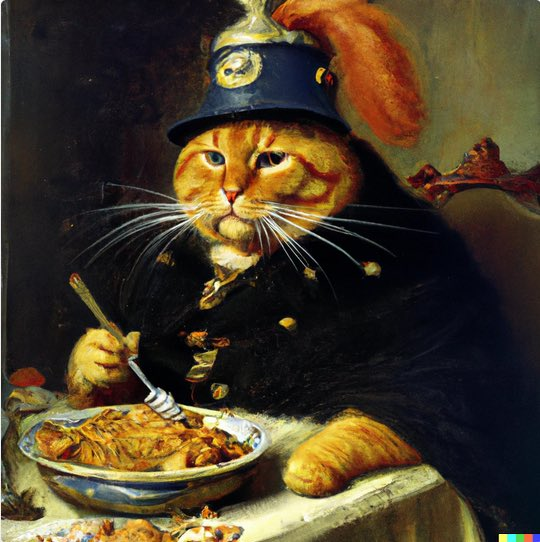  

The main method to do these kind of images is called GAN: Generative Adversial Network.



Generative Adversarial Networks (GANs) are a type of machine learning algorithm that consists of two neural networks: a generator and a discriminator. The generator creates new data instances while the discriminator evaluates the authenticity of these instances. The two networks are trained simultaneously in a game-like process where the generator learns to create increasingly realistic data instances that can fool the discriminator, and the discriminator learns to become more accurate in distinguishing between real and fake data. Through this iterative process, GANs can produce high-quality, realistic outputs such as images, videos, and even music.

# 2. Competition context

The main purpose of this competition is to make a GAN that will be able to generate between 7000 and 10000 images with the style of the famous painter Monet.

The generated images have to be jpg format with a size of 256x256x3 (RGB) and be zipped in a single file named images.zip.  
The evaluation metric used by kaggle to know if the image is considered good is MiFD: **Memorization-informed Fréchet Inception Distance**.  
The smaller MiFID is, the better your generated images are.  
More details can be found at: [Kaggle Competition](https://www.kaggle.com/competitions/gan-getting-started/overview/description).  

# 3. Data Preparation

Based on "Monet CycleGAN Tutorial" notebook from Amy Jang, wich is a tutorial starter for this competition, we will prepare the setup and data we need to implement our GAN. It can be found there:  
[https://www.kaggle.com/amyjang/monet-cyclegan-tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)
  
This notebook gives basis of how data will be loaded inside a kaggle notebook. The method used in this notebbok to generate images is called cycleGAN, that we won't use for the time being.

First of all, we have decided to try executing"Monet CycleGAN Tutorial" notebook to know how it works and how long it takes to train and generate images for the competiton.  
The notebook take around 1h to execute. It trains a CycleGAN on 25 epochs with 300 images with each epoch taking around 40s (except for the first one).  
That notebook generate a bit more than 7000 images that saved on a images.zip file.  
That notebook used a TPU to be run.  
An explanation about TPU and ow it's used on kaggle can be found here: [Kaggle TPU documentation](https://www.kaggle.com/docs/tpu).  
In order to evaluate how TPU is usefull for the executaion, we tried to run the notebook without using TPU.  
After running withou TPU, the same noteboo took around 11h to be executed. We could notice that each training epoch took around 1600s compared to 40s with TPU.  
Based on that, we choose to use TPU as the same way it's used in Amy Jang notebook.  
First, we need to activate the use of TPU (v3-8) on our kaggle notebook like this:  
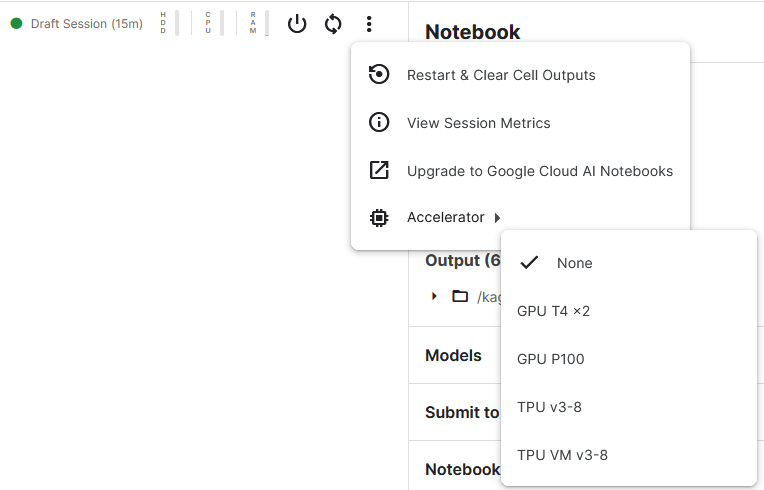

In [2]:
# Library for Data science

import tensorflow as tf #NN processing
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
import time

from IPython import display

In [4]:
# Library for TPU acceleration
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


## Loading Data

The dataset we are using contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg.  
The monet_tfrec and monet_jpg directories contain the same painting images sized 256x256 in JPEG format or TFRecord format, and the photo_tfrec and photo_jpg directories contain the same photos also sized 256x256 in JPEG format or TFRecord format.  

The monet directories contain Monet paintings that we will use for training our models.  
The photo directories contain photos that we will add Monet-style and submit the new generated images.  

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path() #Get path of data from competition dataset

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [7]:
img_sz = 256
IMAGE_SIZE = [img_sz, img_sz]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

##### Define the function to extract the image from the files.



In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [9]:
batch_size = 1 #128*8

In [10]:
# batch_size: number of consecutive elements of this dataset to combine in a single batch --> batch_size=1 will give 1 element in each batch where we have a number of batch=number of elements in the dataset

# 288 allows to be a multiple of 32

if batch_size ==1 or batch_size ==12 :
    monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(batch_size)
    photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(batch_size)
else:
    monet_ds = load_dataset(MONET_FILENAMES, labeled=True).take(288).batch(batch_size)
    photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).take(288).batch(batch_size)

We took one exemple of each of theses lists.

In [11]:
#next : Get following element of the iter(list) each time it is called. 
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's visualize a photo example and a Monet example.

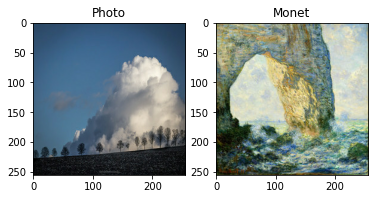

In [12]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

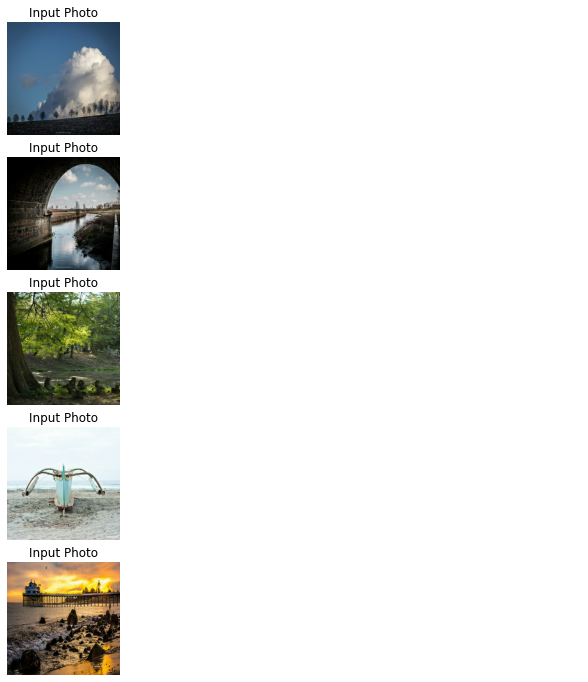

In [13]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    #print(str(i))
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    #ax[i, 1].imshow(monet)
    ax[i, 0].set_title("Input Photo")
    #ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


Calcul of number of elements in datasets.

In [14]:
len_monet_ds = 0
for i in monet_ds:
    #print(i)
    #print(len(i))
    len_monet_ds = len_monet_ds + len(i)
    #len_monet_ds+=1

In [15]:
len_monet_ds #len_data = 

300

In [16]:
len_photo_ds = 0
for i in photo_ds:
    #print(i)
    #len_photo_ds+=1
    len_photo_ds = len_photo_ds + len(i)
len_photo_ds

7038

In [17]:
# monet_ds.cardinality().numpy()
#INFINITE_CARDINALITY	-1
#UNKNOWN_CARDINALITY	-2

# 4. Model preparation

In order to build our GAN, we use the DCGAN tutorial from TensorFlow helping us to prepare all the functions we need: https://www.tensorflow.org/tutorials/generative/dcgan?hl=en  
As this tutorial used a CNN architecture which is not adapted to our problem, we decide to try different architectures that we found on the net.


## 4.1. Different type of Neural Networks

GANs, and specially  computer vision in machine learning use a type of neural networks called Convolutional Neural Networks. CNN are very good to understand differents type of features in image processing. The two NN we will focus use theses types of NN: 

- CNN-based model that proved good results with a lot of epochs.
- CNN based on U-Net model.

The CNN-based scratch model is based on https://www.geeksforgeeks.org/building-a-generative-adversarial-network-using-keras/ made in 2019/06.  
It uses functions and methods which are not really fitted anymore for GAN use (Upsampling2D, relu, ...) but seems to good results for generating images.  

The second one will use methods from pix2pix CNN based on https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en#build_the_generator Tensofflow tutorial in 2022/08. It usually uses a simplified U-Net architecture. It's the same used in the CycleGAN tutorial, without the skips layers because we will generate images from a random vector, not from an input image.  

Let's start by designing the generator and discriminator. Then we will build the GAN architecture.

In [18]:
input_shape = tuple(IMAGE_SIZE) + (3,) #[256,256,3]
input_shape

(256, 256, 3)

### 4.1.1. Generator design  

The first generator design based from the link of GeekForGeek looks like that:

In [19]:
def basic_generator():  
    
        #inputs = keras.Input(shape=input_shape)
        model = tf.keras.Sequential()
  
        #Building the input layer
        model.add(keras.Input(shape=(100,)))
    
        model.add(layers.Dense(128 * 32 * 32, activation="relu"))
        model.add(layers.Reshape((32, 32, 128)))
        
        #print(model.output_shape)  
        model.add(layers.UpSampling2D())
        #print(model.output_shape)
        
        model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.78))
        model.add(layers.LeakyReLU())
          
        model.add(layers.UpSampling2D())
          
        model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.78))
        model.add(layers.LeakyReLU())
        
        #print(model.output_shape)
        model.add(layers.UpSampling2D())
        
        #print(model.output_shape)
        
        model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
        model.add(layers.BatchNormalization(momentum=0.78))
        model.add(layers.LeakyReLU())
        
        #print(model.output_shape)
          
        model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
        model.add(layers.Activation("relu"))
        
        #assert model.output_shape == (None, 28, 28, 1) # we need to be sure our NN will generate an image with the same input_shape as we'll use it as the discriminator input also
        #model.add(layers.Dense(3, activation="relu"))
        """
        last_input = model.output_shape
        print("last_input: " + str(last_input))
        
        k_size = last_input[1] - img_sz*np.sign(last_input[1] - img_sz+1) + 1 # 1: strides of kernel filters
        
        print("k_size: "+str(k_size))
        print(str(np.sign(last_input[1] - img_sz)))
        model.add(layers.Conv2D(3, kernel_size=(k_size,k_size), padding="valid"))
        model.add(layers.Activation("tanh"))
        """
        #print(model.output_shape)
        assert model.output_shape == (None, img_sz, img_sz, 3) # we need to be sure our NN will generate an image with the same input_shape as we'll use it as the discriminator input also
        

        #Generating the output image
        #noise = Input(shape=(latent_dimensions,))
        #image = model(noise)
  
        #return Model(noise, image)
        return model

It's a relatively simple design with few layers.

The second one is based on a U-NET architecture, an efficient architecture used for these types of problems. It's based on the generator based on https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en#build_the_generator and it's quite the same as the one from the CycleGAN tutorial except the skips layers that are used if we try to change the nature of an existing image. But we are generating a new image from a random vector, so these layers should not be needed!

U-Net is a convolutional neural network architecture designed for image segmentation tasks, which involves dividing an image into different regions or objects of interest. The U-Net architecture consists of an encoder and a decoder, which are connected by a bridge that passes information between the two parts of the network. The encoder is made up of several convolutional layers that extract features from the input image, while the decoder uses up-sampling layers to increase the resolution of the feature maps and generate a segmentation map. The architecture also includes skip connections that allow the decoder to use information from earlier layers in the encoder to generate more accurate segmentation maps. The U-Net architecture has been shown to perform well on various medical image segmentation tasks, including segmentation of organs and tumors. An illustration of the U-Net architecture can be found at this URL: (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                         kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [22]:
inp = example_photo[0] * 0.5 + 0.5

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [23]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [25]:
def pix_generator():
    
    #inputs = keras.Input(shape=input_shape)

    #Building the input layer
     
    #inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    inputs = tf.keras.layers.Input(shape=(100,))
    
    x = inputs
    x = layers.Dense(256 * 256 * 3, activation="relu") (x)
    x = layers.Reshape((256, 256, 3))(x)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')  # (batch_size, 256, 256, 3)

    #x = inputs
    """
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    """
    
    # Downsampling through the model
    for down in down_stack:
        x = down(x)

    # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="pix_generator")

In [26]:
def dcgan_generator():
    
    #inputs = keras.Input(shape=input_shape)

    #Building the input layer
     
    #inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    inputs = tf.keras.layers.Input(shape=(100,))
    
    x = inputs
    x = layers.Dense(4 * 4 * 4096, activation="relu") (x)
    x = layers.Reshape((4, 4, 4096))(x)

    up_stack = [
        upsample(2048, 5, apply_dropout=True),  # (batch_size, 8, 8, 2048)
        upsample(1024, 5, apply_dropout=True),  # (batch_size, 16, 16, 1024)
        upsample(512, 5, apply_dropout=True),  # (batch_size, 64, 64, 512)
        upsample(256, 5),  # (batch_size, 128, 128, 256)
        upsample(128, 5),  # (batch_size, 256, 256, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 5,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')  # (batch_size, 256, 256, 3)

    #x = inputs


    # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="dcgan_generator")

In [27]:
"""
def dcgan_generator_2():
    
    #inputs = keras.Input(shape=input_shape)

    #Building the input layer
     
    #inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    inputs = tf.keras.layers.Input(shape=(100,))
    
    x = inputs
    x = layers.Dense(8 * 8 * 2048, activation="relu") (x)
    x = layers.Reshape((8, 8, 2048))(x)

    up_stack = [
        #upsample(2048, 5, apply_dropout=True),  # (batch_size, 8, 8, 2048)
        upsample(1024, 5, apply_dropout=True),  # (batch_size, 16, 16, 1024)
        upsample(512, 5, apply_dropout=True),  # (batch_size, 64, 64, 512)
        upsample(256, 5),  # (batch_size, 128, 128, 256)
        upsample(128, 5),  # (batch_size, 256, 256, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 5,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')  # (batch_size, 256, 256, 3)

    #x = inputs


    # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="dcgan_generator_2")"""

'\ndef dcgan_generator_2():\n    \n    #inputs = keras.Input(shape=input_shape)\n\n    #Building the input layer\n     \n    #inputs = tf.keras.layers.Input(shape=[256, 256, 3])\n    \n    inputs = tf.keras.layers.Input(shape=(100,))\n    \n    x = inputs\n    x = layers.Dense(8 * 8 * 2048, activation="relu") (x)\n    x = layers.Reshape((8, 8, 2048))(x)\n\n    up_stack = [\n        #upsample(2048, 5, apply_dropout=True),  # (batch_size, 8, 8, 2048)\n        upsample(1024, 5, apply_dropout=True),  # (batch_size, 16, 16, 1024)\n        upsample(512, 5, apply_dropout=True),  # (batch_size, 64, 64, 512)\n        upsample(256, 5),  # (batch_size, 128, 128, 256)\n        upsample(128, 5),  # (batch_size, 256, 256, 128)\n    ]\n\n    initializer = tf.random_normal_initializer(0., 0.02)\n    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 5,\n                                     strides=2,\n                                     padding=\'same\',\n                                     ker

In [28]:
def dcgan_generator_2():
    
    #inputs = keras.Input(shape=input_shape)

    #Building the input layer
     
    #inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    inputs = tf.keras.layers.Input(shape=(100,))
    
    x = inputs
    x = layers.Dense(8 * 8 * 1024, activation="relu") (x)
    x = layers.Reshape((8, 8, 1024))(x)

    up_stack = [
        #upsample(2048, 5, apply_dropout=True),  # (batch_size, 8, 8, 2048)
        upsample(512, 5, apply_dropout=True),  # (batch_size, 16, 16, 512)
        upsample(256, 5, apply_dropout=True),  # (batch_size, 64, 64, 256)
        upsample(128, 5),  # (batch_size, 128, 128, 128)
        upsample(256, 5),  # (batch_size, 256, 256, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 5,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')  # (batch_size, 256, 256, 3)

    #x = inputs


    # Upsampling and establishing the skip connections
    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="dcgan_generator_2")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 131072)            13238272  
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 128)       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 256)    

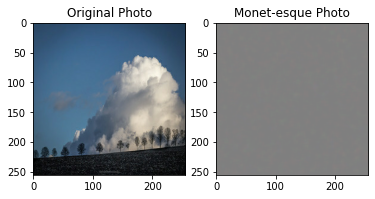

Model: "pix_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 196608)            19857408  
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_4 (Sequential)    (None, 64, 64, 128)       131584    
_________________________________________________________________
sequential_5 (Sequential)    (None, 32, 32, 256)       525312    
_________________________________________________________________
sequential_6 (Sequential)    (None, 16, 16, 512)     

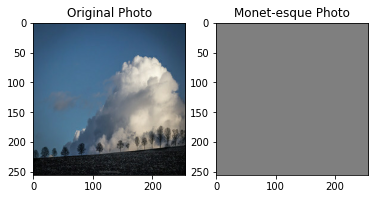

Model: "dcgan_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 4096)        0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 8, 8, 2048)        209723392 
_________________________________________________________________
sequential_19 (Sequential)   (None, 16, 16, 1024)      52432896  
_________________________________________________________________
sequential_20 (Sequential)   (None, 32, 32, 512)       13109248  
_________________________________________________________________
sequential_21 (Sequential)   (None, 64, 64, 256)   

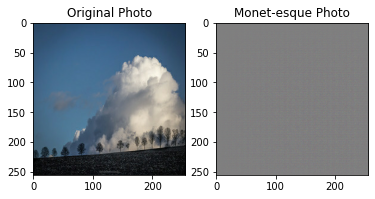

Model: "dcgan_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
sequential_23 (Sequential)   (None, 16, 16, 512)       13109248  
_________________________________________________________________
sequential_24 (Sequential)   (None, 32, 32, 256)       3277824   
_________________________________________________________________
sequential_25 (Sequential)   (None, 64, 64, 128)       819712    
_________________________________________________________________
sequential_26 (Sequential)   (None, 128, 128, 256

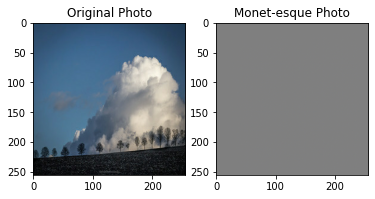

In [29]:
# Exemple of generated images from a photo input passed through ou basic generator
noise_input = tf.random.normal([1, 100])

for test_generator in [basic_generator(),pix_generator(), dcgan_generator(), dcgan_generator_2()]:
    test_generator.summary()

    start = time.time()
    to_monet = test_generator(noise_input)
    print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))

    plt.subplot(1, 2, 1)
    plt.title("Original Photo")
    plt.imshow(example_photo[0] * 0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.title("Monet-esque Photo")
    plt.imshow(to_monet[0] * 0.5 + 0.5)
    plt.show()

We need to generate at least 7000 images in less than 5h (and 3h if we use TPU).  
Let see the average calculation for 100 images generated for each methods.

In [30]:
# Exemple of generated images from a photo input passed through our basic generator

gen_time =[[],[],[],[]]
for num_ex in  range(100):
    
    noise_input = tf.random.normal([1, 100])
    i=0
    for test_generator in [basic_generator(),pix_generator(), dcgan_generator(), dcgan_generator_2()]:
        #test_generator.summary()

        start = time.time()
        to_monet = test_generator(noise_input)
        #print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))
        
        time_gen = time.time()-start
        gen_time[i].append(time_gen)
        i+=1


In [31]:
len(gen_time)

4

In [32]:
len(gen_time[0])

100

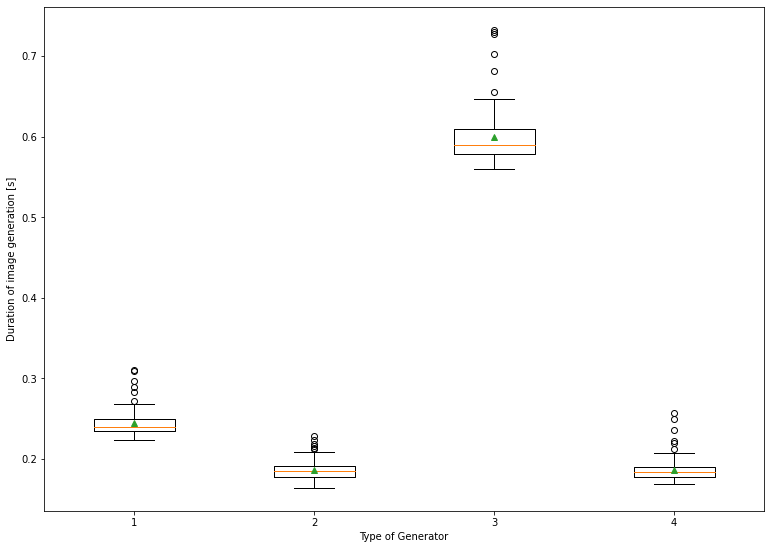

In [33]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(gen_time, showmeans=True)
plt.xlabel("Type of Generator")
plt.ylabel("Duration of image generation [s]")
#plt.legend(['Duration','Mean'])
#ax.legend([bp['boxes'][0],bp['boxes'][1],bp['boxes'][2]],['A','B','C'])
# show plot
plt.show()

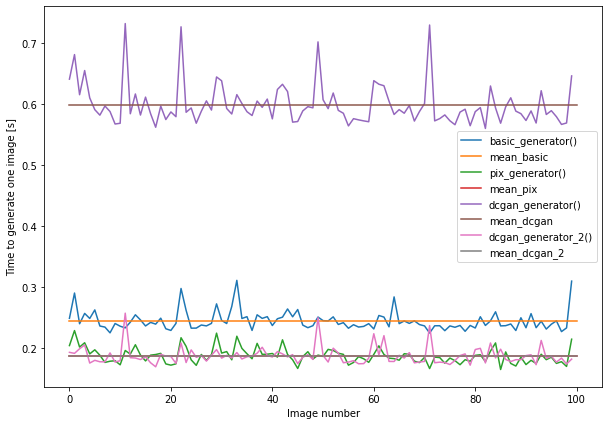

In [34]:
fig = plt.figure(figsize =(10, 7))

for i in range(len(gen_time)):

    plt.plot(gen_time[i])

    #plt.plot(np.mean(gen_time[i]),marker='o')

    plt.plot([0,100],[np.mean(gen_time[i]),np.mean(gen_time[i])])

plt.legend(['basic_generator()','mean_basic','pix_generator()','mean_pix','dcgan_generator()','mean_dcgan','dcgan_generator_2()','mean_dcgan_2'])

plt.xlabel("Image number")
plt.ylabel("Time to generate one image [s]")

plt.show()

In [35]:
"""
fig = plt.figure(figsize =(10, 7))

plt.plot(gen_time[0])
plt.plot(gen_time[1])

plt.plot(np.mean(gen_time[0]),marker='o')
plt.plot(np.mean(gen_time[1]),marker='o')

plt.plot([0,100],[np.mean(gen_time[0]),np.mean(gen_time[0])])
plt.plot([0,100],[np.mean(gen_time[1]),np.mean(gen_time[1])])

plt.legend(['basic_generator()','pix_generator()',
           'mean_','mean_pix'])

plt.xlabel("Image number")
plt.ylabel("Time to generate one image [s]")

plt.show()"""

'\nfig = plt.figure(figsize =(10, 7))\n\nplt.plot(gen_time[0])\nplt.plot(gen_time[1])\n\nplt.plot(np.mean(gen_time[0]),marker=\'o\')\nplt.plot(np.mean(gen_time[1]),marker=\'o\')\n\nplt.plot([0,100],[np.mean(gen_time[0]),np.mean(gen_time[0])])\nplt.plot([0,100],[np.mean(gen_time[1]),np.mean(gen_time[1])])\n\nplt.legend([\'basic_generator()\',\'pix_generator()\',\n           \'mean_\',\'mean_pix\'])\n\nplt.xlabel("Image number")\nplt.ylabel("Time to generate one image [s]")\n\nplt.show()'

 
1h = 3600s . The average time for geenrate images without TPU is 0.25s for pix_generator.  
--> 3600s/0.25s = 14400 images could be generated in one hour.  
We need to generate at least 7000 images in less than 5h (3h if we use TPU).  
This method seems computationnaly valuable. Let's test it.  

In average, the U-net based pix_generator seems quite faster than the basic generator to generate images from an input vector. We choose to continue with the fastest.  

The second method using a U-Net-like architecture seems faster to generate images.  


In [36]:
input_shape

(256, 256, 3)

In [37]:
example_photo.shape

TensorShape([1, 256, 256, 3])

In [38]:
example_photo[0].shape

TensorShape([256, 256, 3])

In [39]:
noise_input.shape

TensorShape([1, 100])

### 4.1.2. Discriminator design  
We build two different types of discriminators. But based on the study made previously with geenrators, we decide to keep the discriminator used with U-net architecture geenrator: pix_discriminator.

In [40]:
def basic_discriminator():
    #Building the convolutional layers
    #to classify whether an image is real or fake
    
    #inputs = tf.keras.Input(shape=input_shape)
    model = tf.keras.Sequential()
  
    #Building the input layer
    model.add(keras.Input(shape=input_shape))
    
    #model = Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.82))
    model.add(layers.LeakyReLU(alpha=0.25))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.82))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.25))
    model.add(layers.Dropout(0.25))
    
    #print(model.output_shape)

    #Building the output layer
    model.add(layers.Flatten())
    print(model.output_shape)
    #assert model.output_shape == (None, 278784)
    model.add(layers.Dense(1, activation='sigmoid'))

    #image = Input(shape=image_shape)
    #validity = model(image)

    #return Model(image, validity)
    return model

In [41]:
def pix_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    #inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    #tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    #x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    x = inputs

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    
    last2 = tf.keras.layers.Flatten()(last)
    last3 = tf.keras.layers.Dense(1)(last2)

    return tf.keras.Model(inputs=inputs, outputs=last3, name="pix_discriminator")

In [42]:
def dcgan_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    #inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    #tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    #x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    x = inputs

    down_stack = [
        downsample(256, 5, apply_batchnorm=False),  # (batch_size, 128, 128, 256)
        downsample(512, 5),  # (batch_size, 64, 64, 512)
        downsample(1024, 5),  # (batch_size, 32, 32, 1024)
        downsample(2048, 5),  # (batch_size, 16, 16, 2048)
        downsample(4096, 5),  # (batch_size, 8, 8, 4096)
        #downsample(8192, 5),  # (batch_size, 4, 4, 8192) #too much computation
    ]
    
    # Downsampling through the model
    
    for down in down_stack:
        x = down(x)
    
    last = tf.keras.layers.Conv2D(1, 5, strides=2,
                                  kernel_initializer=initializer)(x)  # (batch_size, , , 1)
    
    last2 = tf.keras.layers.Flatten()(last)
    last3 = tf.keras.layers.Dense(1, activation='sigmoid')(last2)

    return tf.keras.Model(inputs=inputs, outputs=last3, name="dcgan_discriminator")

In [43]:
def dcgan_discriminator_2():
    initializer = tf.random_normal_initializer(0., 0.02)

    #inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    #tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    #x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    x = inputs

    down_stack = [
        downsample(256, 5, apply_batchnorm=False),  # (batch_size, 128, 128, 256)
        downsample(512, 5),  # (batch_size, 64, 64, 512)
        downsample(1024, 5),  # (batch_size, 32, 32, 1024)
        #downsample(2048, 5),  # (batch_size, 16, 16, 2048)
        #downsample(4096, 5),  # (batch_size, 8, 8, 4096)
        #downsample(8192, 5),  # (batch_size, 4, 4, 8192) #too much computation
    ]
    
    # Downsampling through the model
    
    for down in down_stack:
        x = down(x)
    
    last = tf.keras.layers.Conv2D(1, 5, strides=2,
                                  kernel_initializer=initializer)(x)  # (batch_size, , , 1)
    
    last2 = tf.keras.layers.Flatten()(last)
    last3 = tf.keras.layers.Dense(1, activation='sigmoid')(last2)

    return tf.keras.Model(inputs=inputs, outputs=last3, name="dcgan_discriminator_2")

In [44]:
disc = dcgan_discriminator_2()
np.array_str(disc(example_monet).numpy())

'[[0.6011103]]'

(None, 278784)
Model: "sequential_2530"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1217 (Conv2D)         (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1115 (LeakyReLU) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_808 (Dropout)        (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1218 (Conv2D)         (None, 64, 64, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 65, 65, 64)        0         
_________________________________________________________________
batch_normalization_2630 (Ba (None, 65, 65, 64)        256       
_________________________________________________________________
leaky_re_lu_1116 (LeakyReLU) (None, 

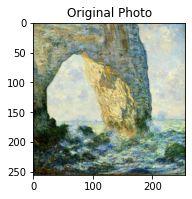

In [45]:
# Too much memory usage
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_monet[0] * 0.5 + 0.5)

for test_discriminator in [basic_discriminator(),pix_discriminator(), dcgan_discriminator(), dcgan_discriminator_2()]:
    test_discriminator.summary()
    
    decision_monet = test_discriminator(example_monet)
    #decision_to_monet = test_discriminator(to_monet)
    print ("decision_monet: " + np.array_str(decision_monet.numpy()) + "\n")
    decision_monet
    #print ("decision_to_monet: " + decision_to_monet)


Choice of Generator and discriminator

In [46]:
# i_gen_disc

i_gen_disc = 0

if i_gen_disc ==0:
    with strategy.scope():
        test_generator = basic_generator()
        test_discriminator = basic_discriminator()
elif i_gen_disc ==1:
    with strategy.scope():
        test_generator = pix_generator()
        test_discriminator = pix_discriminator()
elif i_gen_disc ==2:
    with strategy.scope():
        test_generator = dcgan_generator()
        test_discriminator = dcgan_discriminator()
elif i_gen_disc ==3:
    with strategy.scope():
        test_generator = dcgan_generator_2()
        test_discriminator = dcgan_discriminator_2()

(None, 278784)


In [47]:
"""
# Exemple of generated images from a photo input passed through ou basic generator
noise_input = tf.random.normal([1, 100])

start = time.time()
to_monet = test_generator(noise_input)
print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()"""

'\n# Exemple of generated images from a photo input passed through ou basic generator\nnoise_input = tf.random.normal([1, 100])\n\nstart = time.time()\nto_monet = test_generator(noise_input)\nprint (\'Time for one generated_image from photo is {} sec\'.format(time.time()-start))\n\nplt.subplot(1, 2, 1)\nplt.title("Original Photo")\nplt.imshow(example_photo[0] * 0.5 + 0.5)\n\nplt.subplot(1, 2, 2)\nplt.title("Monet-esque Photo")\nplt.imshow(to_monet[0] * 0.5 + 0.5)\nplt.show()'

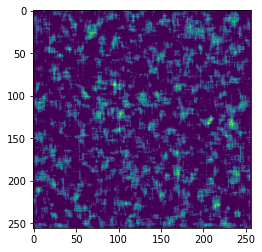

In [48]:
# Image generated from a random image
noise = tf.random.normal([1, 100])
generated_image = test_generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

Time for one generated_image from noise is 0.24130773544311523 sec


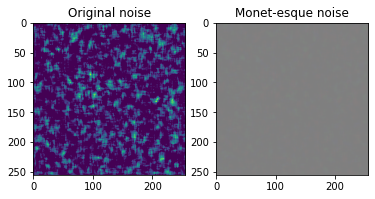

In [49]:
# Exemple of generated images from a photo input passed through ou basic generator
start = time.time()
noise_to_monet = test_generator(noise)
print ('Time for one generated_image from noise is {} sec'.format(time.time()-start))

plt.subplot(1, 2, 1)
plt.title("Original noise")
plt.imshow(generated_image[0, :, :, 0])

plt.subplot(1, 2, 2)
plt.title("Monet-esque noise")
plt.imshow(noise_to_monet[0] * 0.5 + 0.5)
plt.show()

In [50]:
generated_image.shape

TensorShape([1, 256, 256, 3])

In [51]:
generated_image[0].shape

TensorShape([256, 256, 3])

In [52]:
decision = test_discriminator(example_photo)
print (decision)

tf.Tensor([[0.5065473]], shape=(1, 1), dtype=float32)


In [53]:
decision = test_discriminator(generated_image)
print (decision)

tf.Tensor([[0.49993712]], shape=(1, 1), dtype=float32)


## 4.3. Buid the GAN

### 4.3.1. Define the loss and optimizers  

In this part, we'll focus more on the archhitecture of the GAN, and wich loss functions will be used.  
An detailed explanation of how the loss function was chosen can be found here: https://arxiv.org/pdf/1406.2661.pdf  
Let's build the loss functions:

In [54]:
with strategy.scope():
    # This method returns a helper function to compute cross entropy loss
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    
    
    # we need to use reduction=tf.keras.losses.Reduction.NONE because of the use of strategy.scope()
    
    
    """
    ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch size like:
    ```
    with strategy.scope():
        loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    ....
        loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)
    ```
    Please see https://www.tensorflow.org/tutorials/distribute/custom_training for more details.
    """

# UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
#  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
# --> If the discriminator end with sigmoid or softmax, the output will be between 0 to 1, or from_logits=True expect value from -inf to inf. If from_logits=False, values expected are from 0 to 1. That's why we could see an error.

In [55]:
with strategy.scope():
    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

In [56]:
with strategy.scope():
    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [57]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We can test these functions:

In [58]:
generator_loss(noise_to_monet)

<tf.Tensor: shape=(1, 256, 256), dtype=float32, numpy=
array([[[0.691946  , 0.6931472 , 0.6931472 , ..., 0.69287723,
         0.69302225, 0.69307595],
        [0.69294643, 0.6931472 , 0.6931472 , ..., 0.6931472 ,
         0.6931472 , 0.69278455],
        [0.6915373 , 0.6931164 , 0.69188213, ..., 0.69224757,
         0.69259644, 0.6929147 ],
        ...,
        [0.6931472 , 0.6930442 , 0.69213176, ..., 0.69302744,
         0.6922582 , 0.69308615],
        [0.6931472 , 0.69298667, 0.69129705, ..., 0.6930747 ,
         0.6917866 , 0.6930612 ],
        [0.69185597, 0.6914472 , 0.6895514 , ..., 0.69166356,
         0.69116503, 0.69240326]]], dtype=float32)>

In [59]:
discriminator_loss(example_photo,noise_to_monet)

<tf.Tensor: shape=(1, 256, 256), dtype=float32, numpy=
array([[[1.6436129, 1.6424074, 1.6376255, ..., 1.7134857, 1.7133405,
         1.7112918],
        [1.6426084, 1.6376255, 1.6376255, ..., 1.708221 , 1.708221 ,
         1.7084723],
        [1.6392415, 1.6376562, 1.6341276, ..., 1.7092383, 1.7087727,
         1.7083418],
        ...,
        [1.9403548, 1.9572835, 1.902555 , ..., 2.0065286, 1.9825733,
         2.0026515],
        [1.9741184, 1.9461114, 1.9478048, ..., 1.9760798, 2.0039566,
         2.0026765],
        [1.9193933, 1.892271 , 1.9834127, ..., 1.9214344, 2.0084028,
         2.0071545]]], dtype=float32)>

In [60]:
(generator_loss(noise_to_monet) + discriminator_loss(example_photo,noise_to_monet)) /2

<tf.Tensor: shape=(1, 256, 256), dtype=float32, numpy=
array([[[1.1677794, 1.1677773, 1.1653863, ..., 1.2031815, 1.2031814,
         1.2021838],
        [1.1677774, 1.1653863, 1.1653863, ..., 1.2006841, 1.2006841,
         1.2006284],
        [1.1653894, 1.1653863, 1.1630049, ..., 1.200743 , 1.2006845,
         1.2006283],
        ...,
        [1.316751 , 1.3251638, 1.2973434, ..., 1.349778 , 1.3374157,
         1.3478688],
        [1.3336327, 1.3195491, 1.319551 , ..., 1.3345773, 1.3478715,
         1.3478688],
        [1.3056246, 1.2918591, 1.336482 , ..., 1.306549 , 1.3497839,
         1.3497789]]], dtype=float32)>

### 4.3.2. Save checkpoints

In [61]:
# Some tools to save the model during training if an exception occured

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=test_generator,
                                 discriminator=test_discriminator)

In [62]:
# Saving model directories

model_dir = './training_model'
gen_file = os.path.join(model_dir, "model_generator")
disc_file = os.path.join(model_dir, "model_discriminator")

In [63]:
# Tools to save images during training and we'll be used for generating a GIF

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        raw = int(np.around(num_examples_to_generate/5))
        col = 5
        
        plt.subplot(raw, col, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('img_epochs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### 4.3.3. Define training loop  

Here we will define the different training steps and loop to train our model.  
For better understanding, and because we think of using TPU, different ways to train our models will be implemented and tested.

In [64]:
# Some inputs used for training loop
noise_dim = 100
num_examples_to_generate = 3
BATCH_SIZE = batch_size # Comme définit en entrée
#img_sz = 256

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate,noise_dim ])

In [65]:
class GAN_class(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step_to_distribute(self, images):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # add codes to save losses
        #return [gen_loss, disc_loss]
        return (gen_loss + disc_loss)/2
    
    @tf.function
    def distributed_train_step(self, images):
        #images,generator,discriminator = dataset_inputs
        per_replica_losses = strategy.run(self.train_step_to_distribute, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
    
    def train(self, dataset, epochs):
        gen_loss_list  = []
        disc_loss_list = []
        train_loss_list = []
        decision_list = []
        
        for epoch in range(epochs):
            start = time.time()

            total_loss = 0.0
            num_batches = 0
            for image_batch in dataset:
                loss = self.distributed_train_step(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
                train_loss = total_loss / num_batches
                
            train_loss_list.append(train_loss)

                #[gen_loss, disc_loss] = train_step(image_batch,generator,discriminator)
                #gen_loss_list.append(gen_loss)
                #disc_loss_list.append(disc_loss)

            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            generate_and_save_images(self.generator,
                                     epoch + 1,
                                     seed)

            # Save the model every 15 epochs
            #if (epoch + 1) % 15 == 0:
            #    checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) # each line printed is overwritten. The last one is not visible # -> because of display.clear_output(wait=True)?


            # Evaluate the model
            #loss, acc = generator.evaluate(test_images, test_labels, verbose=2)
            #print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))


        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(self.generator,
                               epochs,
                               seed)

        # Losses saved in lists
        #return gen_loss_list, disc_loss_list
        return train_loss_list
    

In [66]:
class GAN_class_bis(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class_bis, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super(GAN_class_bis, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        
    def train_step(self, images):
        
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # add codes to save losses
        #return [gen_loss, disc_loss]
        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "decision":fake_output
            }
 

In [67]:
class GAN_class_2(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class_2, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super(GAN_class_2, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
    
    #@tf.function
    def train_step(self, inputs):
        def step_fn(self, images):

            noise = tf.random.normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = self.generator(noise, training=True)

                real_output = self.discriminator(images, training=True)
                fake_output = self.discriminator(generated_images, training=True)

                gen_loss = self.generator_loss(fake_output)
                disc_loss = self.discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

            # add codes to save losses
            #return [gen_loss, disc_loss]
            return {
                "gen_loss": gen_loss,
                "disc_loss": disc_loss
                }
        per_replica_losses = strategy.run(step_fn, args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
        
        
        """
            @tf.function
    def distributed_train_step(self, images):
        #images,generator,discriminator = dataset_inputs
        per_replica_losses = strategy.run(self.train_step_to_distribute, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
        """

# 5. Train the GAN

In [68]:
EPOCHS = 120 #1200

make_submission = 0 # 0: no generation of images for submission, 1: generate images.zip for submission


# Choice of GAN strategy

iGAN = 1

# 0: monet_gan from GAN_class using distribute and train
# 1: monet_gan_bis from GAN_class_bis using compile and fit
# 2: monet_gan_2 from GAN_class_2 using compile and fit and distribute -> not always working without TPU

In [69]:
#with strategy.scope():
#[gen_loss_list, disc_loss_list] = train(monet_ds, EPOCHS,test_generator,test_discriminator)
#train_loss = train(monet_ds, EPOCHS,test_generator,test_discriminator)

In [70]:
#len(gen_loss_list)

In [71]:
#len(disc_loss_list)

In [72]:
"""
fig = plt.figure(figsize =(10, 7))
plt.plot(gen_loss_list)
plt.plot(disc_loss_list)

plt.plot(np.mean(gen_loss_list),marker='o')
plt.plot(np.mean(disc_loss_list),marker='o')

plt.plot([0,100],[np.mean(gen_loss_list),np.mean(gen_loss_list)])
plt.plot([0,100],[np.mean(disc_loss_list),np.mean(disc_loss_list)])

plt.legend(['gen_loss_list','disc_loss_list',
           'mean_gen_loss_list','mean_disc_loss_list'])

plt.xlabel("Image number")
plt.ylabel("Generator and Discriminator losses")

plt.show()
"""

'\nfig = plt.figure(figsize =(10, 7))\nplt.plot(gen_loss_list)\nplt.plot(disc_loss_list)\n\nplt.plot(np.mean(gen_loss_list),marker=\'o\')\nplt.plot(np.mean(disc_loss_list),marker=\'o\')\n\nplt.plot([0,100],[np.mean(gen_loss_list),np.mean(gen_loss_list)])\nplt.plot([0,100],[np.mean(disc_loss_list),np.mean(disc_loss_list)])\n\nplt.legend([\'gen_loss_list\',\'disc_loss_list\',\n           \'mean_gen_loss_list\',\'mean_disc_loss_list\'])\n\nplt.xlabel("Image number")\nplt.ylabel("Generator and Discriminator losses")\n\nplt.show()\n'

Restore latest checkpoint

In [73]:
if iGAN ==0:
    import os
    os.mkdir("img_epochs")

In [74]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [75]:
if iGAN ==0:
    with strategy.scope():
        monet_gan = GAN_class(test_generator, test_discriminator)

In [76]:
 #%debug
if iGAN ==0:
    #! mkdir img_epochs
    train_loss_result = monet_gan.train(monet_ds, EPOCHS)

In [77]:
if iGAN ==0:
    fig = plt.figure(figsize =(10, 7))
    plt.plot(train_loss_result)

    plt.plot(np.mean(train_loss_result),marker='o')

    plt.plot([0,len(train_loss_result)],[np.mean(train_loss_result),np.mean(train_loss_result)])

    plt.legend(['train_loss_result','mean_train_loss_result'])

    plt.xlabel("Image number")
    plt.ylabel("Generator and Discriminator losses")

    plt.show()

In [78]:
if iGAN ==1:
    with strategy.scope():
        monet_gan_bis = GAN_class_bis(test_generator, test_discriminator)
        monet_gan_bis.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [79]:
#monet_gan_bis.generator.trainable_variables

In [80]:
if iGAN ==1:
    history = monet_gan_bis.fit(monet_ds, epochs = EPOCHS)

Epoch 1/120


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


300/300 [==============================] - 357s 1s/step - gen_loss: 3.3129 - disc_loss: 1.3113 - decision: 0.2330
Epoch 2/120
300/300 [==============================] - 357s 1s/step - gen_loss: 6.0853 - disc_loss: 0.4021 - decision: 0.0729
Epoch 3/120
300/300 [==============================] - 364s 1s/step - gen_loss: 8.8932 - disc_loss: 1.2965 - decision: 0.0925
Epoch 4/120
300/300 [==============================] - 354s 1s/step - gen_loss: 9.4000 - disc_loss: 0.1164 - decision: 0.0191
Epoch 5/120
300/300 [==============================] - 357s 1s/step - gen_loss: 13.2069 - disc_loss: 0.4075 - decision: 0.0397
Epoch 6/120
300/300 [==============================] - 354s 1s/step - gen_loss: 12.7168 - disc_loss: 0.5071 - decision: 0.0312
Epoch 7/120
300/300 [==============================] - 359s 1s/step - gen_loss: 13.7583 - disc_loss: 0.3672 - decision: 0.0289
Epoch 8/120
300/300 [==============================] - 363s 1s/step - gen_loss: 17.3625 - disc_loss: 0.3908 - decision: 0.0202


In [81]:
#monet_gan_bis.generator(noise).shape[0]

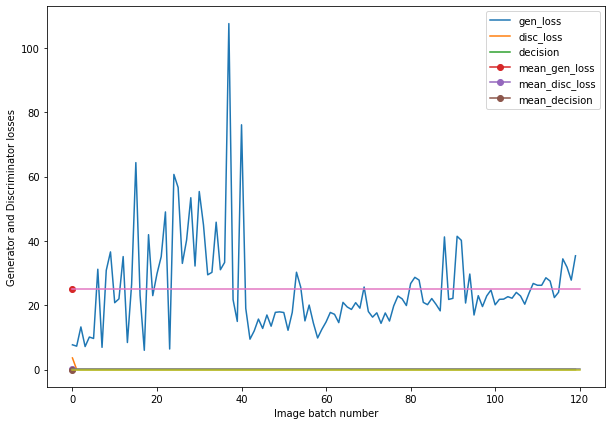

In [82]:
if iGAN ==1:
    fig = plt.figure(figsize =(10, 7))
    #plt.plot([0,len(history.history['gen_loss'])], history.history['gen_loss'])
    plt.plot(np.mean(history.history['gen_loss'], axis=1))
    plt.plot(np.mean(history.history['disc_loss'], axis=1))
    plt.plot(np.mean(history.history['decision'], axis=1))

    plt.plot(np.mean(np.mean(history.history['gen_loss'], axis=1)),marker='o')
    plt.plot(np.mean(np.mean(history.history['disc_loss'], axis=1)),marker='o')
    plt.plot(np.mean(np.mean(history.history['decision'], axis=1)),marker='o')

    plt.plot([0,len(np.mean(history.history['gen_loss'], axis=1))],[np.mean(np.mean(history.history['gen_loss'], axis=1)),np.mean(np.mean(history.history['gen_loss'], axis=1))])
    plt.plot([0,len(np.mean(history.history['disc_loss'], axis=1))],[np.mean(np.mean(history.history['disc_loss'], axis=1)),np.mean(np.mean(history.history['disc_loss'], axis=1))])
    plt.plot([0,len(np.mean(history.history['decision'], axis=1))],[np.mean(np.mean(history.history['decision'], axis=1)),np.mean(np.mean(history.history['decision'], axis=1))])


    plt.legend(['gen_loss','disc_loss','decision','mean_gen_loss','mean_disc_loss','mean_decision'])

    plt.xlabel("Image batch number")
    plt.ylabel("Generator and Discriminator losses")

    plt.show()

In [83]:
#history.history['gen_loss']

In [84]:
#np.mean(history.history['gen_loss'], axis=1)

In [85]:
#history.history['gen_loss'][0]

In [86]:
#history.history['gen_loss'][0][-1]

In [87]:
#history.history['decision']

In [88]:
#np.mean(history.history['decision'], axis=1)

In [89]:
#history.history['gen_loss'][][-1]

In [90]:
if iGAN ==2:
    with strategy.scope():
        monet_gan_2 = GAN_class_2(test_generator, test_discriminator)
        monet_gan_2.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [91]:
if iGAN ==2:
    monet_gan_2.fit(monet_ds, epochs = EPOCHS)

In [92]:
# #Stop runing
#import sys
#sys.exit()

# 6. Test the GAN 

Création de GIF

In [93]:
if iGAN ==0:
    # Display a single image using the epoch number
    def display_image(epoch_no):
        return PIL.Image.open('img_epochs/image_at_epoch_{:04d}.png'.format(epoch_no))

In [94]:
if iGAN ==0:
    display_image(EPOCHS)

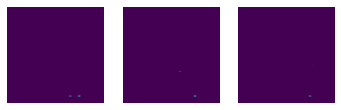

In [95]:
if iGAN == 0:
    generator_to_test = monet_gan.generator
elif iGAN == 1:
    generator_to_test = monet_gan_bis.generator
elif iGAN == 2:
    generator_to_test = monet_gan_2.generator


fig = plt.figure(figsize=(10, 10))

#num_examples_to_generate = 10
for i in range(generator_to_test(seed).shape[0]):
    raw = int(np.around(num_examples_to_generate/5))
    col = 5

    plt.subplot(raw, col, i+1)
    plt.imshow(generator_to_test(seed)[i, :, :, 0] * 127.5 + 127.5)
    plt.axis('off')

## Animated Gif

In [96]:
if iGAN ==0:
    import imageio.v2 as imageio

    anim_file = 'dcgan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('img_epochs/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [97]:
if iGAN ==0:
    # To generate GIFs
    ! pip install imageio
    ! pip install git+https://github.com/tensorflow/docs

In [98]:
if iGAN ==0:
    import tensorflow_docs.vis.embed as embed
    embed.embed_file(anim_file)

# 7. Save model

In [99]:
# Saving model

model_dir = './training_model'
gen_file = os.path.join(model_dir, "model_generator")
disc_file = os.path.join(model_dir, "model_discriminator")

In [100]:
# Methods for saving the generated folder of saved trained model in a file that we can easily download in kaggle
from zipfile import ZipFile
import os

def save_model_zip(test_folder,zip_file):

    #zip_file = "test_folder.zip"  # zip file name
    directory = test_folder

    with ZipFile(zip_file, 'w') as zip_obj:
        for path, directories, files in os.walk(directory):
            for file in files:
                file_name = os.path.join(path, file)

                zip_obj.write(file_name) # zipping the file

    print("Contents of the zip file:")
    with ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.printdir()

In [101]:
# Saving actions if using CPU/GPU
"""   
monet_gan.generator.save(gen_file) # + str(epoch))
monet_gan.discriminator.save(disc_file) # + str(epoch))

zip_file = os.path.join(model_dir, "gan_model_file.zip")
#save_model_zip(gen_file,zip_file)
#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent
save_model_zip(model_dir,zip_file)"""

#from IPython.display import FileLink
#FileLink(gen_file)
#FileLink(disc_file)

'   \nmonet_gan.generator.save(gen_file) # + str(epoch))\nmonet_gan.discriminator.save(disc_file) # + str(epoch))\n\nzip_file = os.path.join(model_dir, "gan_model_file.zip")\n#save_model_zip(gen_file,zip_file)\n#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent\nsave_model_zip(model_dir,zip_file)'

In [102]:
# Saving actions if using TPU

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

if iGAN ==0:
    monet_gan.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan.discriminator.save(disc_file, options=save_locally) 
elif iGAN ==1:
    monet_gan_bis.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan_bis.discriminator.save(disc_file, options=save_locally) 
elif iGAN ==2:
    monet_gan_2.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan_2.discriminator.save(disc_file, options=save_locally)     
    
zip_file = os.path.join(model_dir, "gan_model_file.zip")
#save_model_zip(gen_file,zip_file)
#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent
save_model_zip(model_dir,zip_file)

Contents of the zip file:
File Name                                             Modified             Size
training_model/gan_model_file.zip              2023-03-30 05:06:12            0
training_model/model_generator/saved_model.pb  2023-03-30 05:06:08       319768
training_model/model_generator/keras_metadata.pb 2023-03-30 05:06:08        28192
training_model/model_generator/variables/variables.index 2023-03-30 05:06:08         1536
training_model/model_generator/variables/variables.data-00000-of-00001 2023-03-30 05:06:08     55631776
training_model/model_discriminator/saved_model.pb 2023-03-30 05:06:12       330170
training_model/model_discriminator/keras_metadata.pb 2023-03-30 05:06:12        29012
training_model/model_discriminator/variables/variables.index 2023-03-30 05:06:12         1508
training_model/model_discriminator/variables/variables.data-00000-of-00001 2023-03-30 05:06:12      2685185


# 8. Create submission file

In [103]:
if make_submission == 1:
    ! mkdir ../images

In [104]:
if make_submission == 1:
    i = 1
    nb_img2gen = 7000
    for img in range(nb_img2gen):
        noise = tf.random.normal([1, 100])

        if iGAN ==0:
            prediction = monet_gan.generator(noise, training=False)[0].numpy()
        elif iGAN ==1:
            prediction = monet_gan_bis.generator(noise, training=False)[0].numpy()
        elif iGAN ==2:
            prediction = monet_gan_2.generator(noise, training=False)[0].numpy()

        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("../images/" + str(i) + ".jpg")
        i += 1

In [105]:
if make_submission == 1:
    import shutil
    shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")